# Cost-Sensitive Fraud Detection with Threshold Optimization

This notebook presents an applied study on cost-sensitive machine learning
for fraud detection under extreme class imbalance, serving as an initial
exploration toward a PhD research agenda in behavior-aware fraud systems.


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)


In [28]:
!pip install lightgbm


Defaulting to user installation because normal site-packages is not writeable


In [29]:
df = pd.read_csv("creditcard.csv")
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Feature Engineering

df["hour_of_day"] = (df["Time"] / 3600) % 24
df["log_amount"] = np.log1p(df["Amount"])

X = df[["hour_of_day", "log_amount"]]
y = df["Class"]


SPLIT

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [31]:
import lightgbm as lgb

In [32]:
baseline = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42
)

baseline.fit(X_train, y_train)
baseline_probs = baseline.predict_proba(X_test)[:, 1]


[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339


COST-SENSITIVE MODEL

In [33]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

cost_model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

cost_model.fit(X_train, y_train)
cost_probs = cost_model.predict_proba(X_test)[:, 1]


[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339


In [34]:
def evaluate_threshold(y_true, probs, threshold, cost_fp=1, cost_fn=10):
    preds = (probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    recall = tp / (tp + fn)
    fpr = fp / (fp + tn)
    cost = (fp * cost_fp) + (fn * cost_fn)
    return recall, fpr, cost


threshold            0.810000
recall               0.632653
fpr                  0.295864
expected_cost    17184.000000
Name: 40, dtype: float64

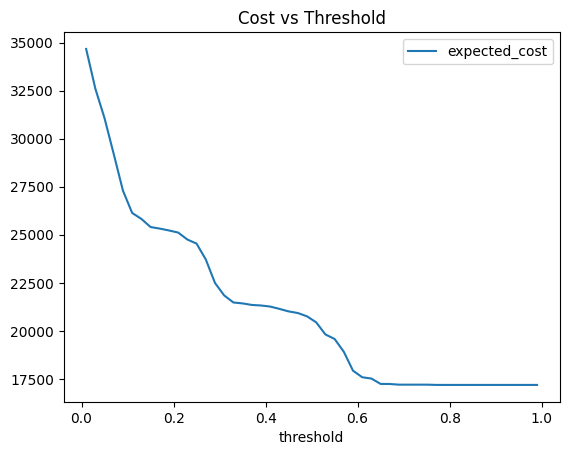

In [35]:
thresholds = np.linspace(0.01, 0.99, 50)
records = []

for t in thresholds:
    recall, fpr, cost = evaluate_threshold(y_test, cost_probs, t)
    records.append([t, recall, fpr, cost])

results = pd.DataFrame(
    records,
    columns=["threshold", "recall", "fpr", "expected_cost"]
)

best = results.sort_values("expected_cost").iloc[0]
results.plot(x="threshold", y="expected_cost", title="Cost vs Threshold")
best


C:\Users\prabh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


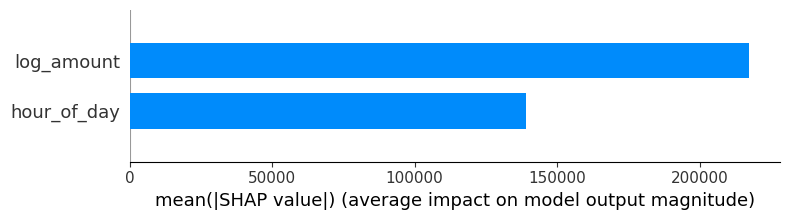

In [37]:
import shap
explainer = shap.TreeExplainer(cost_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")
